# Regridding from one coordinate system to another with pyproj

This post follows on from a [previous post](http://climate-cms.org/2021/10/01/pyproj.html) which covered converting between coordinate systems with [pyproj](https://pyproj4.github.io/pyproj/stable/).

Some cells have `jupyter` magic `%%time` commands for no other reason than to give an indication of how long these operations typically take. Having an expectation of how long something should take is a useful metric for knowing when something is not working correctly.



In [1]:
import cosima_cookbook as cc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from numpy import s_
import pyproj
import xarray as xr

## Sample data in polar projection

The sample dataset here is [MEaSUREs BedMachine Antarctica, Version 2](https://nsidc.org/data/NSIDC-0756/versions/2).

The source data by default runs positive to negative in `y`. The `sortby` method reorders the `y` axis to run negative to positive.

In [2]:
data = xr.open_dataset('/g/data/hh5/tmp/aph502/BedMachineAntarctica_2020-07-15_v02.nc', 
                         chunks={'x': 5000, 'y': 5000}).sortby('y')

In [3]:
data

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    bed        (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(3333, 5000), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

The data is very large: 13333 x 13333 points. Using a subset makes plotting faster which allows for a quick inspection of the bedrock altitude (topography and bathymetry) data. 

Note that the `numpy` `s_` operator is used to generate slices (see [s_ numpy docs](https://numpy.org/doc/stable/reference/generated/numpy.s_.html)). Note also that this equivalent to `data.bed[0::50,0::50]` but `isel` is used because it is more explicit as it names the axes.

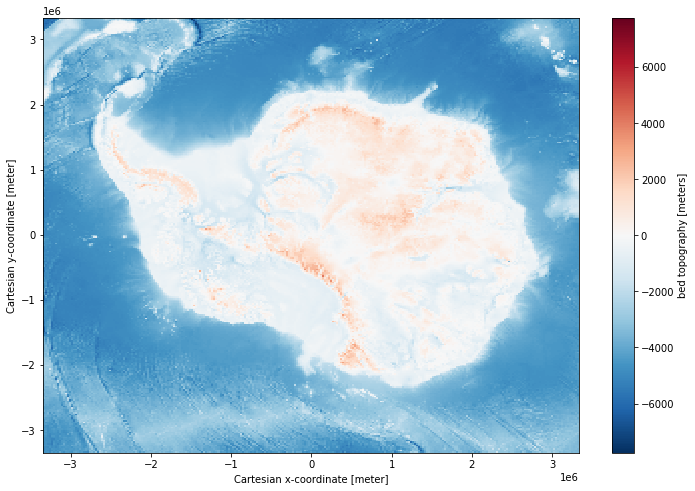

In [4]:
data.bed.isel(x=s_[0::50], y=s_[0::50]).plot(size=8);

## Interpolate to ACCESS-OM2-01 grid

Now interpolate the original bathymetry data onto the ACCESS-OM2 0.1° grid

The ACCESS-OM2 grid contains a tripole in the northern hemisphere, to avoid a point of convergence over the ocean. As a result it requires a curvilinear grid. This does not affect the southern hemisphere, so it is sufficient to use the cartesian grid.

Load the cartesian grid from an ACCESS-OM2-01 experiment.

In [5]:
session = cc.database.create_session()

expt = '01deg_jra55v140_iaf'

xt_ocean = cc.querying.getvar(expt, 'xt_ocean', session, n=-1)
yt_ocean = cc.querying.getvar(expt, 'yt_ocean', session, n=-1)

The ACCESS-OM2 grid is global, so need to trim the latitude to match the maximum extent of the bedmachine data (53S according to the website but some experimentation shows the maximum latitude extent is about 48.3S))

In [6]:
yt_ocean = yt_ocean.sel(yt_ocean=slice(-91,-48))

[pyproj](https://pyproj4.github.io/pyproj/stable/) is a Python interface to [proj](https://proj.org), 

    "PROJ is a generic coordinate transformation software that transforms geospatial coordinates from one coordinate reference system (CRS) to another"

It can be used to convert between different coordinate systems. The EPSG code for basic lat-lon coordinates is 'epsg:4326'.

To convert between coordinate systems you create a 'Transformer', then 'transform' the coordinate values.

In this case the longitude/latitude positions from the ACCESS-OM2 grid can be transformed into the same coordinate system as the original data, though the positions will likely not correspond to exact locations of the original gridded data, but the values of the variables at those positions can be interpolated from surrounding grid locations. Once this is done the result will be interpolated values of the original data at positions of the ACCESS-OM2 grid.

Create a grid of lat/lon values for the ACCESS-OM2 grid

In [7]:
lonmesh, latmesh = np.meshgrid(xt_ocean, yt_ocean)

Define the source and target projections

In [8]:
source_crs = pyproj.CRS(init="epsg:3031") # Coordinate system of the file
target_crs = pyproj.CRS(init="epsg:4326") # Global lat-lon coordinate system

Create a `pyproj.Transformer` to transform each point in `lonmesh` and `lastmesh` into a location in the bedmachine coordinates

In [9]:
latlon_to_polar = pyproj.Transformer.from_crs(target_crs, source_crs)

In [10]:
x_om2, y_om2 = latlon_to_polar.transform(lonmesh, latmesh)

Use the `xarray` `interp` method to find the nearest locations for each transformed point from the ACCESS-OM2 grid. To do this need to create `xarray.DataArray` for the coordinates with matching dimensions.

In [11]:
x_om2 = xr.DataArray(x_om2, dims=('lat','lon'))
y_om2 = xr.DataArray(y_om2, dims=('lat','lon'))

Do a simple nearest-neighbour interpolation. The `interp` operator also [supports linear interpolation for two dimensions](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.interp.html). 

Nearest neighour is used in this case for simplicity: some of the variables (e.g. `mask`) are categorical and not suited to an interpolation method which creates non-integer values. If required it would be straightforward to split the interpolation into two steps, linear interpolation one for continuous variables, nearest neighbour for categorical. 

This interpolates eight 2D variables in the dataset: the `mapping` variable is dropped because it cannot be interpolated and throws an error. 

In [12]:
%%time
data_om2 = data.drop_vars('mapping').interp({'x':x_om2, 'y':y_om2}, method='nearest').load()
data_om2

CPU times: user 21.7 s, sys: 4.95 s, total: 26.6 s
Wall time: 20.1 s


<xarray.Dataset>
Dimensions:    (lat: 696, lon: 3600)
Coordinates:
    x          (lat, lon) float64 9.534e+05 9.537e+05 ... 4.689e+06 4.69e+06
    y          (lat, lon) float64 1.672e+05 1.656e+05 ... 8.395e+05 8.313e+05
Dimensions without coordinates: lat, lon
Data variables:
    mask       (lat, lon) float64 2.0 2.0 2.0 2.0 2.0 ... nan nan nan nan nan
    firn       (lat, lon) float32 37.24 37.23 37.22 37.21 ... nan nan nan nan
    surface    (lat, lon) float32 3.967e+03 3.965e+03 3.962e+03 ... nan nan nan
    thickness  (lat, lon) float32 2.971e+03 2.791e+03 2.698e+03 ... nan nan nan
    bed        (lat, lon) float32 996.2 1.175e+03 1.263e+03 ... nan nan nan
    errbed     (lat, lon) float32 40.0 40.0 35.0 33.0 38.0 ... nan nan nan nan
    source     (lat, lon) float64 5.0 5.0 5.0 5.0 5.0 ... nan nan nan nan nan
    geoid      (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

Use `xarray.plot` to check it looks ok. Note the patterm of missing data in this projection, as the source data is square in polar-stereo.

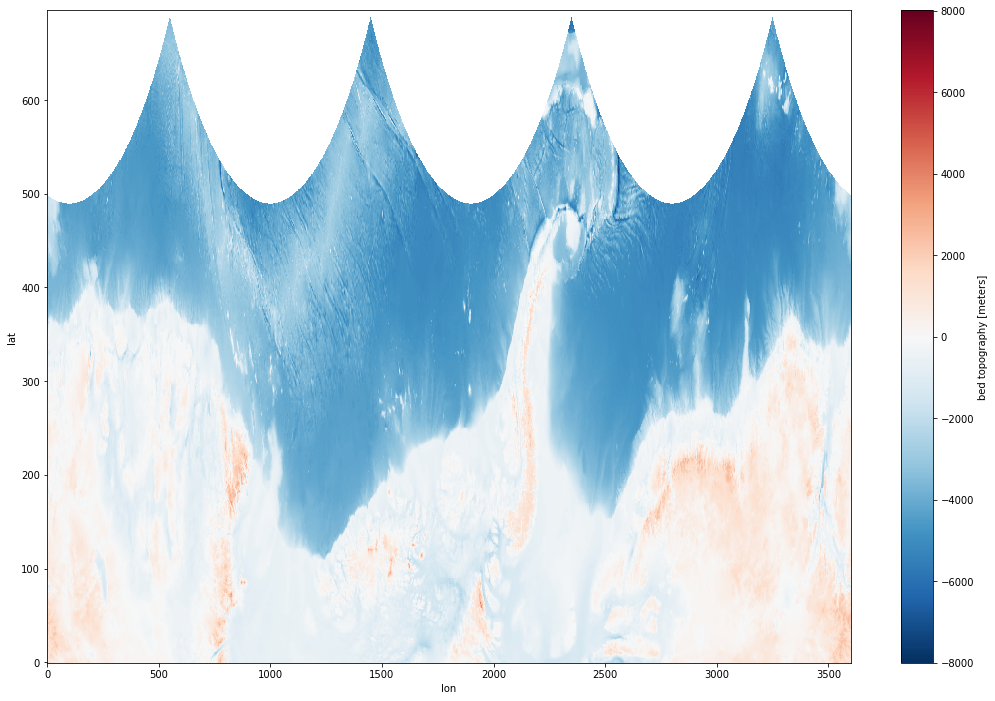

In [13]:
data_om2.bed.plot(size=12);

Now `data_om2` contains interpolated bathymetric depths at each point of the ACCESS-OM2 grid. Next step is to add the ACCESS-OM2 latitude and longitude coordinates, and drop the transformed polar-stereo coordinates.

In [14]:
data_om2 = data_om2.assign_coords({'lon': (('lon'), xt_ocean.data), 'lat': (('lat'), yt_ocean.data)}).drop_vars(['x','y']).reset_coords()

In [15]:
data_om2

<xarray.Dataset>
Dimensions:    (lat: 696, lon: 3600)
Coordinates:
  * lon        (lon) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * lat        (lat) float64 -81.11 -81.07 -81.02 ... -48.19 -48.13 -48.06
Data variables:
    mask       (lat, lon) float64 2.0 2.0 2.0 2.0 2.0 ... nan nan nan nan nan
    firn       (lat, lon) float32 37.24 37.23 37.22 37.21 ... nan nan nan nan
    surface    (lat, lon) float32 3.967e+03 3.965e+03 3.962e+03 ... nan nan nan
    thickness  (lat, lon) float32 2.971e+03 2.791e+03 2.698e+03 ... nan nan nan
    bed        (lat, lon) float32 996.2 1.175e+03 1.263e+03 ... nan nan nan
    errbed     (lat, lon) float32 40.0 40.0 35.0 33.0 38.0 ... nan nan nan nan
    source     (lat, lon) float64 5.0 5.0 5.0 5.0 5.0 ... nan nan nan nan nan
    geoid      (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

Now plot in South Polar Stereo to compare with the original data. 

Note that the easiest way to set the axes extent is to specify them using the extent of the original data and specify the projection. If the extent is specified in latitude and longitude `cartopy` will transform them into the projected space and calculate a bounding box and in this case will leave whitespace surrounding the plot.

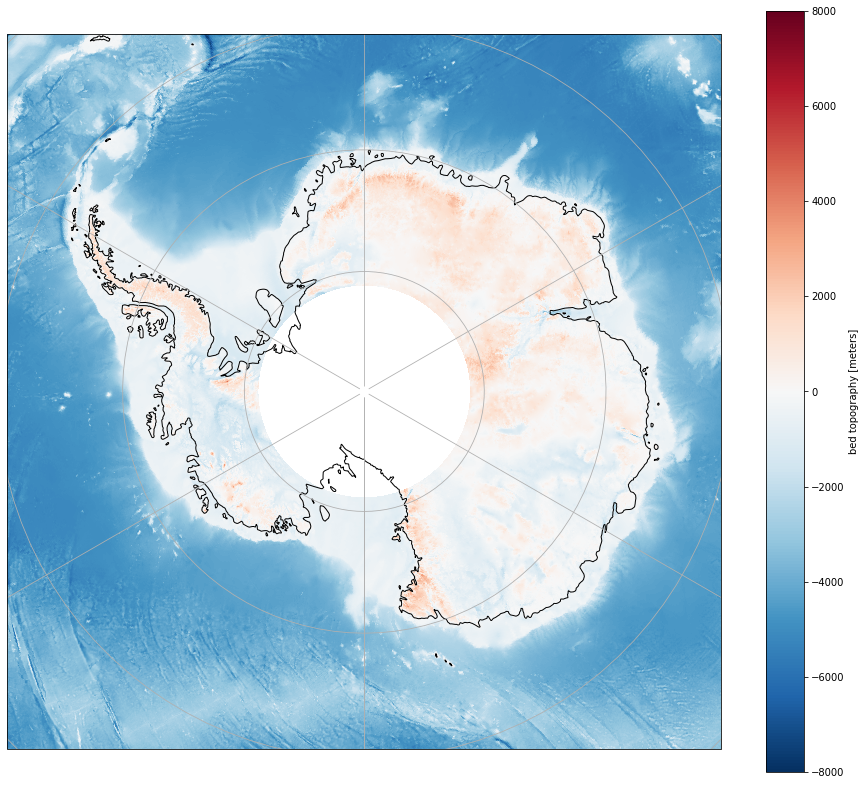

In [16]:
fig = plt.figure(figsize=(16, 14))
projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

ax.set_extent((-3333000, 3333000, -3333000, 3333000), crs=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')

ax.gridlines()
data_om2.bed.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree());

The data contains a `mask` variable, with all values of ocean equal to zero. To compare to the original ACCESS-OM2 bathymetry the interpolated `bed` variable can be masked with `where`, which correctly excludes the the ice shelves

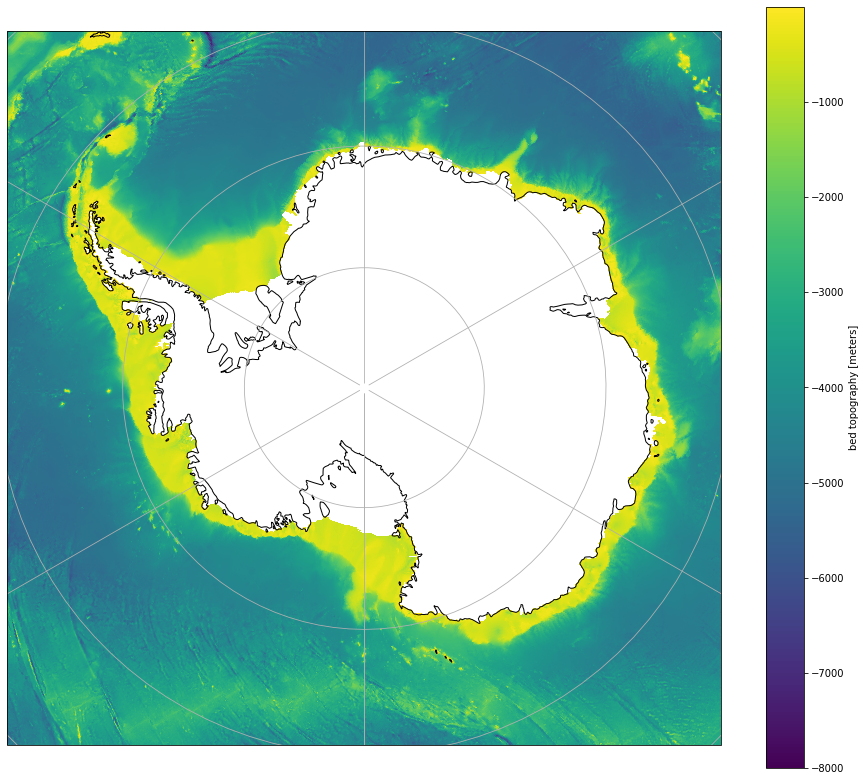

In [17]:
fig = plt.figure(figsize=(16, 14))
projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

ax.set_extent((-3333000, 3333000, -3333000, 3333000), crs=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')

ax.gridlines()
data_om2.bed.where(data_om2.mask==0).plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree());

Now save the data to disk for re-use

In [18]:
%%time
data_om2.to_netcdf('bedmachine_om2.nc')

CPU times: user 40.6 ms, sys: 70.2 ms, total: 111 ms
Wall time: 234 ms


## Other interpolation methods

Accurately down-sampling topographic data is problematic, [averaging smooths out troughs and peaks, local interpolation or nearest-neighbour interpolation can be noisier](https://www.geospatialworld.net/article/comparison-of-decimation-and-averaging-methods-of-dems-resampling/). For these reasons it is a reasonable approach to regrid this data. 

It is likely not appropriate for other fields, at least not scientifically rigorous, but can be a useful approach as a quick interpolation method for visualisation or roughly scoping out a problem.

There are other methods for interpolating geospatial data that provide more options and flexbility, but at the expense of some complexity.

For example [xesmf can do 2D bilinear or even conservative interpolation](https://coecms.github.io/2021/04/09/xesmf-regrid.html) but often requires some work to get the files into the appropriate form and can be very computationally expensive, [requiring hundreds of CPUs to generate the weighting file in a timely fashion for a problem of this size](https://pangeo-xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html). In contrast this method, though approximate, takes only 20s to regrid all eight variables.

There are popular command line utilities that can interpolate the data, e.g. [cdo](https://code.mpimet.mpg.de/projects/cdo/wiki/Tutorial#Horizontal-fields) but it has to be compiled with `proj` support, and [nco](http://nco.sourceforge.net/nco.html#ncremap) but that may require providing a grid for the source data in longitude/latitude coordinates.